In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn import preprocessing

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct
from sklearn.gaussian_process.kernels import ConstantKernel as C
from sklearn.gaussian_process.kernels import WhiteKernel as W

# 1. Data Preprocesssing
### Print data information

In [3]:
# Items = ['Open time','Open','High','Low','Close','Volume','Close time','Quote','Trade num','Takerbase','Takerquote','Ignore']
Items = ['Close', 'High', 'Low', 'Volume', 'Trade num']
CoinSym = ['BTC']

Original_Data = pd.read_csv('./BTCUSDT_2017-01-01_2018-01-01_1d.csv')
# Original_Data = pd.read_csv('./BTCUSDT_2017-12-01_2018-02-01_1d.csv')
# Original_Data = pd.read_csv('./BTCUSDT_2018-01-01_2018-01-01_5m.csv')

print('Key features {}'.format(Items))

Key features ['Close', 'High', 'Low', 'Volume', 'Trade num']


### Data Plot

Total Number of Dataset: 1467
Keys in Table ['Close', 'High', 'Low', 'Volume', 'Trade num']
Maximum in Table [  63575.         64854.         62020.        402201.673764
 6331062.      ]
Averages in Table [ 14244.59605999  14669.82298569  13697.98479209  50754.61215445
 694442.19631902]
Minimum in Table [3189.02     3276.5      2817.        228.108068 2153.      ]


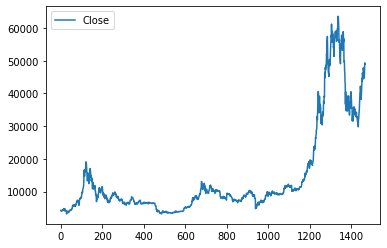

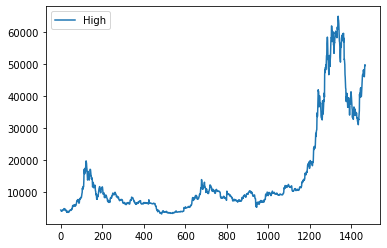

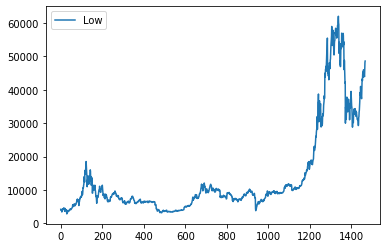

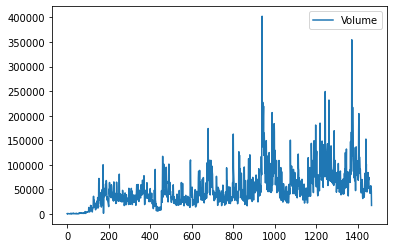

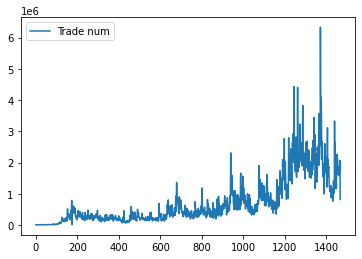

In [4]:
DataMatrix = Original_Data[Items].astype('float')
TotalNum = np.shape(DataMatrix)[0]
print('Total Number of Dataset:', TotalNum)
print('Keys in Table',list(DataMatrix.keys()))
print('Maximum in Table {}'.format(np.max(DataMatrix.values,axis=0)))
print('Averages in Table {}'.format(np.mean(DataMatrix.values,axis=0)))
print('Minimum in Table {}'.format(np.min(DataMatrix.values,axis=0)))
for key in DataMatrix.keys():
    DataMatrix.plot(y=key)

### Prepare Data for auto-regressive model

$$
X_t = f\left(X_{t-1},X_{t-2},\cdots,X_{t-m+1},X_{t-m}\right)
$$

In [4]:
# Select_Items = ["Close"]

TrainingNum = 500   # number of candles
ar_order = 3

X_train_list = []
for m in range(ar_order):
    X_train_list.append([DataMatrix["Close"][m:TrainingNum+m]])

X_train = np.concatenate(X_train_list).T
y_train = DataMatrix["Close"][ar_order:TrainingNum+ar_order]

TestNum = TotalNum - TrainingNum - ar_order
X_test_list = []
for m in range(ar_order):
    X_test_list.append([DataMatrix["Close"][TrainingNum+m:TrainingNum+TestNum+m]])

X_test = np.concatenate(X_test_list).T
y_test = DataMatrix["Close"][TrainingNum+ar_order:TrainingNum+TestNum+ar_order]

### Rescale data

In [5]:
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 3. Train Auto-regressive model

### We use Gaussian process regression to learn auto-regressive model

In [20]:
# Instantiate a Gaussian Process model
kernel = C() * RBF() + DotProduct() + W()
gp = GaussianProcessRegressor(kernel=kernel, normalize_y=True, n_restarts_optimizer=100)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train_scaled, y_train)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_train_pred, sigma_train = gp.predict(X_train_scaled, return_std=True)
y_test_pred, sigma_test = gp.predict(X_test_scaled, return_std=True)

c:\users\cau\appdata\local\programs\python\python39\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


1 step prediction error:1169.630301665904


c:\users\cau\appdata\local\programs\python\python39\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "


In [33]:
print('1 step prediction training error:{:.03f} USD'.format(np.sqrt(np.mean((y_train_pred - y_train)**2.))))
print('1 step prediction test error:{:.03f} USD'.format(np.sqrt(np.mean((y_test_pred - y_test)**2.))))

1 step prediction training error:240.051 USD
1 step prediction test error:1169.630 USD


### Plot 1-step Prediction

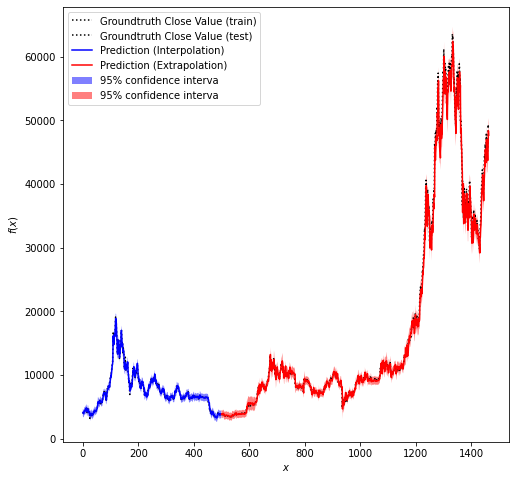

In [21]:
plt.figure(figsize=(8,8))
plt.plot(range(TrainingNum), y_train, 'k:', label=r'Groundtruth Close Value (train)')
plt.plot(range(TrainingNum, TrainingNum+TestNum), y_test, 'k:', label=r'Groundtruth Close Value (test)')
plt.plot(range(TrainingNum), y_train_pred, 'b-', label='Prediction (Interpolation)')
plt.fill(np.concatenate([range(TrainingNum),range(TrainingNum)[::-1]]),
         np.concatenate([y_train_pred - 1.9600 * sigma_train,
                        (y_train_pred + 1.9600 * sigma_train)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interva')
plt.plot(range(TrainingNum,TrainingNum+TestNum), y_test_pred, 'r-', label='Prediction (Extrapolation)')
plt.fill(np.concatenate([range(TrainingNum, TrainingNum+TestNum),range(TrainingNum, TrainingNum+TestNum)[::-1]]),
         np.concatenate([y_test_pred - 1.9600 * sigma_test,
                        (y_test_pred + 1.9600 * sigma_test)[::-1]]),
         alpha=.5, fc='r', ec='None', label='95% confidence interva')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()

plt.show()

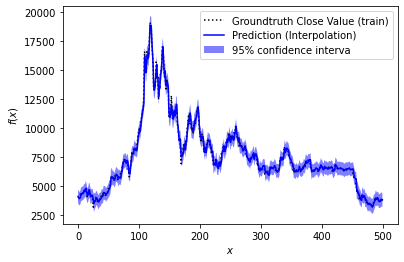

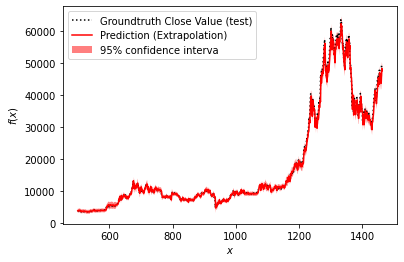

In [22]:
plt.figure()
plt.plot(range(TrainingNum), y_train, 'k:', label=r'Groundtruth Close Value (train)')
plt.plot(range(TrainingNum), y_train_pred, 'b-', label='Prediction (Interpolation)')
plt.fill(np.concatenate([range(TrainingNum),range(TrainingNum)[::-1]]),
         np.concatenate([y_train_pred - 1.9600 * sigma_train,
                        (y_train_pred + 1.9600 * sigma_train)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interva')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

plt.figure()
plt.plot(range(TrainingNum, TrainingNum+TestNum), y_test, 'k:', label=r'Groundtruth Close Value (test)')
plt.plot(range(TrainingNum,TrainingNum+TestNum), y_test_pred, 'r-', label='Prediction (Extrapolation)')
plt.fill(np.concatenate([range(TrainingNum, TrainingNum+TestNum),range(TrainingNum, TrainingNum+TestNum)[::-1]]),
         np.concatenate([y_test_pred - 1.9600 * sigma_test,
                        (y_test_pred + 1.9600 * sigma_test)[::-1]]),
         alpha=.5, fc='r', ec='None', label='95% confidence interva')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.legend()
plt.show()

### k-step prediction